In [ ]:
#Decent Efficnet model in train and validation

#freezing layers speeds up training

#resize 338x338 #NOTE this is not the expected size
#batch size 16
#BCEWithLogitsLoss
#no augmentation
#Adam
#lr=0.001

In [16]:
#import packages
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import pathlib
from torch.utils.data import Dataset

import numpy as np
#from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch
import torchvision
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

In [74]:
#good practice to provide class labels as integer arrays

CLASSES = ["BLD", "No BLD"]
class_mapping = {label: idx for idx, label in
                 enumerate(np.unique([CLASSES]))}


{'BLD': 0, 'No BLD': 1}


In [69]:
#dictonary to modify transformations
config = dict(
    rot=90,
    noise=0.05
)

In [70]:
#make sure image input size matches expected size for the spcific models

train_transform = transforms.Compose(
    #384x384 for efficientnet
    #224x225 for ResNEt and MobileNEt
    #256x256 for Swin
    [transforms.Resize([384,384]), #converts image to the pre-trained model dimension expectations
     #transforms.RandomRotation(degrees=config["rot"]),
     #transforms.RandomVerticalFlip(p=0.5),
     #transforms.RandomHorizontalFlip(p=0.5),
     transforms.Grayscale(3),
     transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
    ])

#validation preprocessing
val_transform = transforms.Compose(
    [transforms.Resize([384,384]), #converts image to the pre-trained model dimension expectations
     transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
     ])
     

In [71]:
#import data
#images in directories converted to tensor format and classes obtained from direcory names

train_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/train', transform=train_transform)
#test_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/test', transform=val_transform)
val_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/val', transform=val_transform)

In [72]:
# Access the transformed image
image, label = train_dataset[0]
# Check the size of the transformed image
print(image.shape) #retuns [channel, height, width]. 3 indicates color. During training an additional element is added, batch_size


torch.Size([3, 384, 384])


In [73]:
train_dataset.class_to_idx

{'BLD': 0, 'No_BLD': 1}

In [131]:
print(f'Number of images in training dataset: {len(train_dataset)}')
#print(f'Number of images in testing dataset: {len(test_dataset)}')
print(f'Number of images in validation dataset: {len(val_dataset)}')

Number of images in training dataset: 80
Number of images in validation dataset: 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


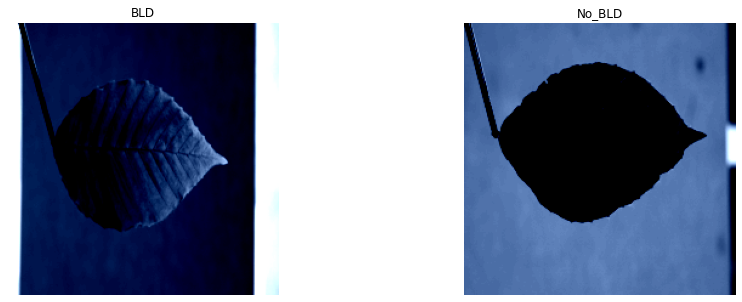

In [152]:
#Bing
#how to print example of each image class from dataset pytorch

# Create a dictionary to store one example per class
class_examples = {}

# Iterate through the dataset to find one example per class
for img, label in train_dataset:
    if label not in class_examples:
        class_examples[label] = img
    if len(class_examples) == len(train_dataset.classes):
        break

# Plot the examples
fig, axes = plt.subplots(1, len(class_examples), figsize=(15, 5))
for idx, (label, img) in enumerate(class_examples.items()):
    axes[idx].imshow(img.permute(1, 2, 0))
    axes[idx].set_title(train_dataset.classes[label])
    axes[idx].axis('off')


In [154]:
#a hyperparameter to try changing
#batch_size = 4
batch_size = 16
#batch_size = 32

In [155]:
#dataloader
#output a batch of images and labels, one sample at a time

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
#                                         shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True)



In [77]:
#print class for each sample in batch
train_features, train_labels = next(iter(trainloader))
print(train_labels)

tensor([0, 1, 0, 1])


In [ ]:
#Visualize

Feature batch shape: torch.Size([4, 3, 384, 384])
Labels batch shape (number): torch.Size([4])


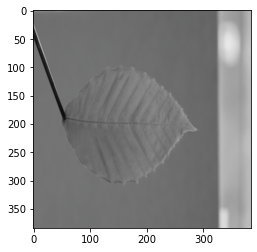

Label: ['No BLD']
Label: 1


In [81]:
# Display image and label.
#to pull out a single image and label, first put in individual variables
#https://stackoverflow.com/questions/61480762/python-matplotlib-invalid-shape-for-image-data

train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape (number): {train_labels.size()}")
img = train_features[0].numpy().transpose((1, 2, 0)) #changing the channel and dimension order for plotting
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {[CLASSES[label]]}")
print(f"Label: {train_labels[0]}")

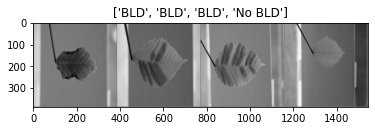

tensor([0, 0, 0, 1])


In [83]:
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[CLASSES[x] for x in classes])
print(classes)

In [26]:
#Import model for training

#EfficientNet V2
weights = EfficientNet_V2_S_Weights.DEFAULT
model_EFV2 = efficientnet_v2_s(weights=weights)



In [9]:
#first set of code NOT freezing layers

In [30]:
#EfficientNet

#Intitalize model, not freezing layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_efv2 = model_EFV2

#freeze layers
for param in model_EFV2.parameters():
    param.requires_grad = False

num_ftrs = model_efv2.classifier[1].in_features #print this out to confirm a value

num_classes = 2  # Replace with the number of classes in your dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_efv2.classifier[1] = nn.Linear(in_features=model_efv2.classifier[1].in_features, out_features=num_classes)

#move model to this device
model_efv2 = model_efv2.to(device)

#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_efv2.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [31]:
#Pg. 479 pytorch book
#modified to accomidate BCELoss format expectations in the pred output
#Pg. 473
#If returning 1 probablity from model(x_batch) (using [:,0]), then use BCE function
#If retunring 2 proabability values, use Cross entropy loss function

def train(model, num_epochs, train_d1, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for x_batch, y_batch, in train_d1:
            #output of forward pass a tensor with predictions for the batch
            pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
            #print(pred.size(), y_batch.size()) #use this to troubleshoot BCE error. Shapes should match
            loss = criterion(pred, y_batch.float()) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float() #calculating correct class from first column of pred tensor [:,0]
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_d1.dataset)
        accuracy_hist_train[epoch] /= len(train_d1.dataset)
        
        model.eval() 
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
                loss = criterion(pred, y_batch.float()) #BCE expects floar
                loss_hist_valid[epoch] += \
                    loss.item() * y_batch.size(0)
                is_correct = \
                    ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_d1.dataset)
            accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

            print(f'Epoch {epoch+1} ' 
                  f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
                  f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
                  f'train_loss: {loss_hist_train[epoch]:.4f}, '
                  f'val_loss: {loss_hist_valid[epoch]:.4f} ')
    return loss_hist_train, loss_hist_valid, \
        accuracy_hist_train, accuracy_hist_valid          

In [32]:
#Train model not frozen
torch.manual_seed(1)
num_epochs = 5
hist = train(model_efv2, num_epochs, trainloader, valloader)

Epoch 1 accuracy: 0.8625, val_accuracy: 0.9615, train_loss: 0.3978, val_loss: 0.2862 
Epoch 2 accuracy: 1.0000, val_accuracy: 0.9615, train_loss: 0.1505, val_loss: 0.1303 
Epoch 3 accuracy: 0.9750, val_accuracy: 0.9615, train_loss: 0.0999, val_loss: 0.1066 
Epoch 4 accuracy: 0.9750, val_accuracy: 0.9615, train_loss: 0.0835, val_loss: 0.1017 
Epoch 5 accuracy: 0.9750, val_accuracy: 0.9615, train_loss: 0.0622, val_loss: 0.1001 


In [ ]:
#training without data augmentataion in the training set produces a solid training learning curve (accuracy and loss)
#validation still stuck

#ideas
#increase batch size
#decrease learning rate
#try different optimizers
#train longer 
#scaling features
#changing features

#https://stackoverflow.com/questions/52356068/validation-accuracy-constant-in-keras-cnn-for-multiclass-image-classification
#https://www.tutorialspoint.com/fixing-constant-validation-accuracy-in-cnn-model-training#:~:text=In%20this%20post%2C%20we%27ll%20talk%20about%20a%20few,tuning%2C%20regularization%2C%20optimizer%20selection%2C%20initialization%2C%20and%20hyperparameter%20tweaking.
#https://www.researchgate.net/post/How_to_tackle_the_problem_of_constant_val_accuracy_in_CNN_model_training
#https://stackoverflow.com/questions/51933123/how-to-fix-a-constant-validation-accuracy-in-machine-learning
#https://datascience.stackexchange.com/questions/13607/validation-loss-and-accuracy-remain-constant


In [ ]:
#errors with data augmentation decreasing training accuracy
#https://discuss.pytorch.org/t/why-data-augmentation-leads-to-decreased-accuracy-when-finetuning/3600

In [ ]:
#Evaluation metrics

In [203]:
#precision, recall, f1


def eval_model(model, valid_d1):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for x_batch, y_batch in valloader:
            pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
            #set threshold to make prediction 0 or 1
            y_p = ((pred>=0.5).float())
            all_preds.extend(y_p.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            # Compute precision
        precision = precision_score(all_labels, all_preds, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
            #calculate recall score
        recall = recall_score(all_labels, all_preds, average='binary')
            #Calculate f1 score
        f1 = f1_score(all_labels, all_preds, average='binary')
                    
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1: {f1:.4f}')
            

In [204]:
#evaluate
torch.manual_seed(1)

hist = eval_model(model_efv2, valloader)

Precision: 0.9091
Recall: 1.0000
F1: 0.9524


In [ ]:
#Precision and recall
#by epoch

def eval_model(model, num_epochs, valid_d1):
    y_pred = []
    y_true = []
    for epoch in range(num_epochs):
        model.eval() 
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
                #loss = criterion(pred, y_batch.float()) #BCE expects floar
                y_pred = ((pred>=0.5).float()) 

                # Convert lists to tensors for calculation
                y_true_tensor = np.array(y_batch)
                y_pred_tensor = np.array(y_pred)
                        

                          
                # Calculate precision score
                precision_hist_valid = precision_score(y_true_tensor, y_pred_tensor, average='binary')
                #calculate recall score
                recall_hist_valid = recall_score(y_true_tensor, y_pred_tensor, average='binary')
                #Calculate f1 score
                f1_hist_valid = f1_score(y_true_tensor, y_pred_tensor, average='binary')

            print(f'Epoch {epoch+1} ' 
                  f'Precision Score: {precision_hist_valid:.4f} '
                  f'Recall Score: {recall_hist_valid:.4f} '
                  f'F1 Score: {f1_hist_valid:.4f}'
            )
            
    #return loss_hist_valid, accuracy_hist_valid, precision_hist_valid

        

In [177]:
#evaluate
torch.manual_seed(1)
num_epochs = 5
hist = eval_model(model_efv2, num_epochs, valloader)

Precision Score: 0.9091 Recall Score: 1.0000 F1 Score: 0.9524
Precision Score: 0.9091 Recall Score: 1.0000 F1 Score: 0.9524
Precision Score: 0.9091 Recall Score: 1.0000 F1 Score: 0.9524
Precision Score: 0.9091 Recall Score: 1.0000 F1 Score: 0.9524
Precision Score: 0.9091 Recall Score: 1.0000 F1 Score: 0.9524


In [218]:
from sklearn.metrics import roc_auc_score

In [231]:
#ROC
#Precision, recall, f1 score
#need to double check this is calculated correctly
#i patched this code together from different sources

def eval_roc(model, valid_d1):
    all_preds = []
    all_labels = []
    model.eval() 
    with torch.no_grad():
        for x_batch, y_batch in valid_d1:
            #need to save probabilities
            outputs = model(x_batch)
            probs, preds = torch.max(outputs, 1)
            
            #print(probs)
        
            
            #applying sigmoid activation function to prediction probabilities
            #https://pytorch.org/ignite/generated/ignite.metrics.ROC_AUC.html
            trans_probs = torch.sigmoid(probs)
            
            print(preds)
            print(trans_probs)
        
        #append values    
        all_preds.extend(trans_probs.cpu().numpy())
        all_labels.extend(preds.cpu().numpy())
        #print(all_preds)
        #print(all_labels)

            
        # Calculate ROC AUC
        auc = roc_auc_score(all_preds, all_labels)
        print(f'ROC AUC: {auc}')
                

In [232]:
#evaluate
torch.manual_seed(1)

hist = eval_roc(model_efv2, valloader)

tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1])
tensor([0.4444, 0.9892, 0.4571, 0.4334, 0.4642, 0.4456, 0.4704, 0.9814, 0.9804,
        0.4560, 0.9526, 0.4545, 0.9585, 0.9900, 0.8054, 0.4951])
tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 0])
tensor([0.9822, 0.5132, 0.4550, 0.9791, 0.5002, 0.9616, 0.4323, 0.4475, 0.4602,
        0.9862])
ROC AUC: 0.0


In [ ]:
#ROC troubleshooting

#might be labeling incorecttly
#https://stackoverflow.com/questions/54693550/roc-auc-value-is-0

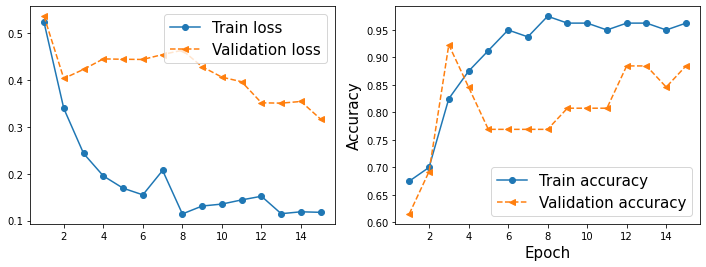

In [16]:
#Plot learning curve
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize = 15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<',
        label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size=15)
plt.show()




In [30]:
#To freeze all but last layer for training 
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


model_conv = torchvision.models.efficientnet_v2_s()
for param in model_conv.parameters():
    param.requires_grad = False #freeze all but last layer

num_classes = 2  # Replace with the number of classes in your dataset
# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)

model_conv = model_conv.to(device)

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [122]:
#Pg. 494 pytorch book
def train(model, num_epochs, train_d1, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for x_batch, y_batch, in train_d1:
            #output of forward pass a tensor with predictions for the batch
            pred = model(x_batch)[:,0] #[:,0] slices the first column of the tensor for all items in the batch
            loss = criterion(pred, y_batch.float()) #swaped in 'criterion'. #.float() ensures data are in correct type
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_d1.dataset)
        accuracy_hist_train[epoch] /= len(train_d1.dataset)
        
        model.eval() 
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0]
                loss = criterion(pred, y_batch.float()) #swapped in criterion
                loss_hist_valid[epoch] += \
                    loss.item() * y_batch.size(0)
                is_correct = \
                    ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_d1.dataset)
        accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

        print(f'Epoch {epoch+1} ' 
              f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
              f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
              f'train_loss: {loss_hist_train[epoch]:.4f}, '
              f'val_loss: {loss_hist_valid[epoch]:.4f} ')
    return loss_hist_train, loss_hist_valid, \
        accuracy_hist_train, accuracy_hist_valid

In [123]:
#Train model frozen layers
torch.manual_seed(1)
num_epochs = 5
hist = train(model_conv, num_epochs, trainloader, valloader)

NameError: name 'model_conv' is not defined